## Mở đầu.
Về cơ bản, `image thresholding` sẽ tạo ra những hình ảnh có dạng như `nhị phân` thông qua một giá trị ngưỡng nào đó, hay `threshold value`, theo đó 
- Nếu vượt quá ngưỡng này `RetVa`, thì các `pixel-value` sẽ được gán bằng `0`, `255` hoặc `fixed`, theo `simple thresholding`
- Ngược lại, các giá trị không vượt qua ngưỡng này có thể được cố định hoặc gán bằng `0` hoặc `255` để tạo ra gam màu đối lập với những giá trị đã vượt ngưỡng `RetVa`.
- Vì hình của chúng ta mong muốn có dạng `binarization (hay nhị phân)` nên `input image` phải có dạng `gray scale`

Trong phần này, chúng ta sẽ tìm hiểu về các `thresholding-image` qua các khái niệm `simple threshold, adaptive threshold` và `Otsu threshold`

In [2]:
import cv2
import numpy as np
import skimage.io as si
import matplotlib.pyplot as plt

## 1. Simple thresholding
#### Reminder.
Để tải một hình dưới dạng `gray scale`, ta có thể dùng trực tiếp bằng

$\qquad \qquad$ `cv2.imread(path_img, 0)`

hoặc

$\qquad \qquad$ `cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)`

trong đó: `color_image = cv2.imread(path_img)`

**Common Syntax (Simple Thresholding).**

                cv2.threshold(input_image, RetVa, MaxVa, threshold_flag)
                
**Example**                

In [3]:
path = r'../input/nhabnn/mang.JPG'
image = cv2.imread(path)
img0 = cv2.imread(path, 0)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
images = [img0, img_gray]
h, w = img0.shape
sep = 80*"="
out = []

for k in range(2):
    RetVa, RetIm = cv2.threshold(images[k], 155, 255, cv2.THRESH_BINARY)
    print('Cach %s, RetVa =  %s'%(k+1, RetVa))
    out.append(RetIm)

print('%s \n Is RetIm(img0) is pointwised-equally RetIm(img_gray)? %s \
          \n Is img0 is pointwised-equally img_gray? %s \
        \n%s \n proportion of different-region of (img0, img_gray) = %s \
          \n proportion of different-region of (RetIm(img0), RetIm(img_gray)) = %s'%
      (sep, (RetIm[0] == RetIm[1]).all(), (img0 == img_gray).all(), 
       sep, ((img0 != img_gray).sum() / (h*w)) , ((RetIm[0] != RetIm[1]).sum() / (h*w)))
     )

Cach 1, RetVa =  155.0
Cach 2, RetVa =  155.0
 Is RetIm(img0) is pointwised-equally RetIm(img_gray)? False           
 Is img0 is pointwised-equally img_gray? False         
 proportion of different-region of (img0, img_gray) = 0.032958261002935044           
 proportion of different-region of (RetIm(img0), RetIm(img_gray)) = 0.0002614351745341225


Như vậy vì cách thức tải dạng `gray-scale` từ `cv2.imread(flag = 0)` có chút khác biệt với sau khi sử dụng `cv2.cvtColor(flag = cv2.COLOR_BGR2GRAY)` nên mặc dù `RetVa` trong 2 trường hợp này là như nhau nhưng chúng vẫn tồn tại sự khác biệt.

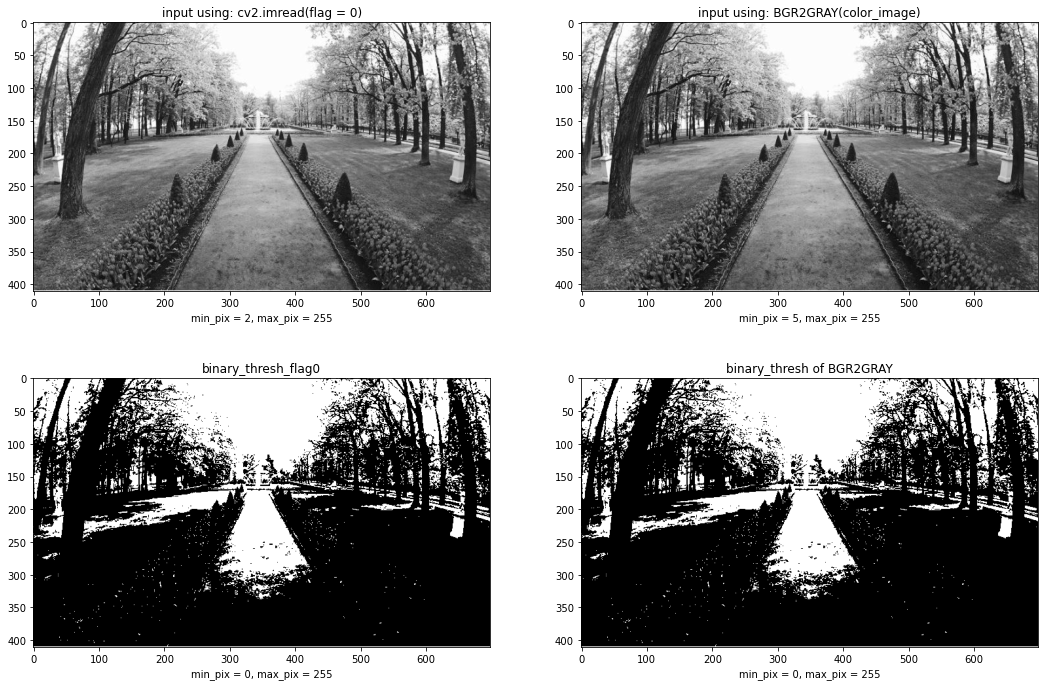

In [4]:
images += out
titles = ['input using: cv2.imread(flag = 0)', 'input using: BGR2GRAY(color_image)', 
          'binary_thresh_flag0', 'binary_thresh of BGR2GRAY']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))
ax = ax.ravel()
for k in range(4):
    ax[k].imshow(images[k], cmap = 'gray')
    ax[k].set_title(titles[k])
    ax[k].set_xlabel('min_pix = %s, max_pix = %s'%(images[k].min(), images[k].max()))
    #ax[k].set_axis_off()

Tiếp theo, ta sẽ tìm hiểu các loại `simple thresholding`, tới hiện nay trong `OpenCV` ta có 5 loại `thresholding` phổ biến
### 1.1. Binary-thresholding & Binary_Inverse_thresholding.
2 dạng này hiển nhiên sẽ đảo ngược với nhau trong định nghĩa, vậy định nghĩa của chúng chính xác là gì?

|  | Binary thresholding | Binary_inverse thresholding |
|-|-|-|
|**Defintion function**| $f_{bt}(x) = $ `MaxVa *`$1_{\lbrace x < \text{ RetVa} \rbrace}$ | $f_{bit} = $ `MaxVa *`$1_{\lbrace x \geq \text{ RetVa} \rbrace}$ = `MaxVa -` $f_{bt}(x)$ |
|**`flag` (in `OpenCV`)**| `THRESH_BINARY` | `THRESH_BINARY_INV` |
|         (by integer) | 0 | 1| 

In [5]:
cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV

(0, 1)


Theo đó, 
- `output image` là các hình chỉ có 2 pixel values là `MaxVa` và `0` và 
- hiển nhiên là các giá trị bằng `0` trong `threshold image` khi dùng `THRESH_BINARY` sẽ có giá trị là `MaxVa` khi sử dụng `THRESH_BINARY_INV` và ngược lại.

| **Example** | Binary thresholding | Binary_inverse thresholding |
|-|:-:|:-:|
|`RetVa = 100, MaxVa = 255`| $f_{bt}(200) = 255 =$ `MaxVa` | $f_{bit}(200) = 0$ |
|`RetVa = 100, MaxVa = 255`| $f_{bt}(20) = 0$  | $f_{bit}(20) = 255 = $ `MaxVa`|
|`RetVa = 100, MaxVa = 205`| $f_{bt}(200) = 205 =$ `MaxVa` | $f_{bit}(200) = 0$ |
|`RetVa = 100, MaxVa = 205`| $f_{bt}(20) = 0$ | $f_{bit}(20) = 205 =$ `MaxVa` |

Sau đây, hãy xem thử sự khác nhau về pixel value trong ví dụ đơn giản sau:

In [6]:
pixel = np.uint8([[255, 210, 230, 144, 244], [121, 140, 174, 121, 121]])
print('Given pixel = \n %s'%pixel)
MaxVas = [220, 240, 255]
flags = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV]
flag_names = ['binary', 'binary_inv']
RetVa = 128
for k in range(2):
    for MaxVa in MaxVas:
        ret_vl, ret_pix = cv2.threshold(pixel, RetVa, MaxVa, flags[k])
        print('For RetVa = %s, MaxVa = %s, flag = "%s", then \n ret_pix = \n %s'%(ret_vl, MaxVa, flag_names[k], ret_pix))

Given pixel = 
 [[255 210 230 144 244]
 [121 140 174 121 121]]
For RetVa = 128.0, MaxVa = 220, flag = "binary", then 
 ret_pix = 
 [[220 220 220 220 220]
 [  0 220 220   0   0]]
For RetVa = 128.0, MaxVa = 240, flag = "binary", then 
 ret_pix = 
 [[240 240 240 240 240]
 [  0 240 240   0   0]]
For RetVa = 128.0, MaxVa = 255, flag = "binary", then 
 ret_pix = 
 [[255 255 255 255 255]
 [  0 255 255   0   0]]
For RetVa = 128.0, MaxVa = 220, flag = "binary_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [220   0   0 220 220]]
For RetVa = 128.0, MaxVa = 240, flag = "binary_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [240   0   0 240 240]]
For RetVa = 128.0, MaxVa = 255, flag = "binary_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [255   0   0 255 255]]


Sau đây, hãy xem sự khác nhau giữa 2 flags này cũng như khi thay đổi `MaxVa` và `RetVa`

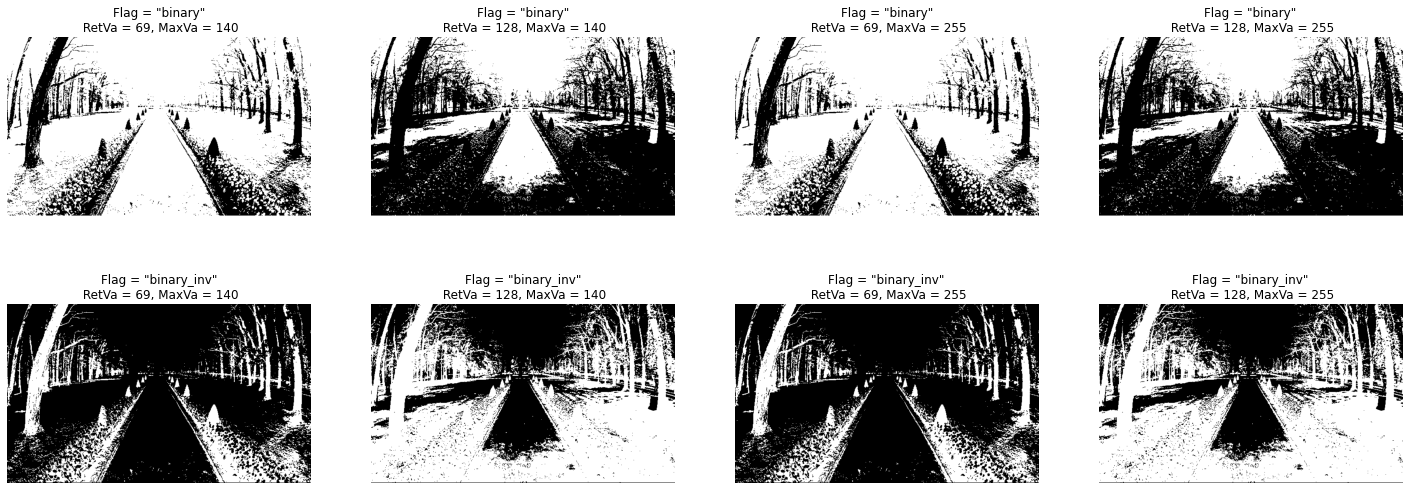

In [7]:
MaxVas = [140, 255]
RetVas = [69, 128]
flags = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV]
flag_names = ['binary', 'binary_inv']
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 9))
ax = ax.ravel()
for r in range(2):
    for c in range(4):
        RetVa, Ret_Im = cv2.threshold(img_gray, RetVas[c % 2], MaxVas[c // 2], flags[r])    
        ax[4*r + c].imshow(Ret_Im, cmap = 'gray')
        ax[4*r + c].set_title('Flag = "%s"\n RetVa = %s, MaxVa = %s'%(flag_names[r], RetVas[c % 2], MaxVas[c // 2]))
        ax[4*r + c].set_axis_off()

### Comments.
- Rõ ràng gam màu trong `binary_inv` là đối lập tương ứng với như trong `binary`.
- Với cùng mức `RetVa`, thì các pixel dưới ngưỡng `RetVa` có giá trị như nhau bất kể khi ta thay đổi `MaxVa`
- Đối với `flag = "binary"`, `RetVa` càng thấp thì gam màu trắng sẽ càng nhiều vì `RetVa` càng thấp sẽ dẫn đến các pixel trong khu vực `cận-tối` (vượt qua `RetVa` không nhiều, ví dụ `RetVa = 70` trong khi ngưỡng tối của hình là 65) sẽ chuyển thành gam màu sáng (với giá trị `MaxVa`).

### 1.2. Tozero-thresholding & Tozero-inverse thresholding.
Khác với `binary thresholding`, giá trị ở những pixel khi đã vượt ngưỡng `RetVa` trong `tozero thresholding` sẽ được cố định. Do đó,

|  | Tozero thresholding | Tozero_inverse thresholding |
|-|-|-|
|**Defintion function**| $f_{tt}(x) = x$ * $1_{\lbrace x < \text{ RetVa} \rbrace}$ | $f_{tit}(x) = x$ * $1_{\lbrace x \geq \text{ RetVa} \rbrace}$ = `pixel_value -` $f_{bt}(x)$ |
|**`flag` (in `OpenCV`)**| `THRESH_TOZERO` | `THRESH_TOZERO_INV` |
|         (by integer) | 3 | 4| 

In [8]:
cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV

(3, 4)

Theo đó, 
- `output image` là các hình **không chỉ có 2 pixel values** vì nó gồm `pixel_values` và `pixel_zero(0)` 
- hiển nhiên là các giá trị bằng `0` trong `threshold image` khi dùng `THRESH_TOZERO` sẽ có giá trị là `pixel_values` khi sử dụng `THRESH_TOZERO_INV` và ngược lại.
- Khác với `binary` và `binary_inv`, dù cho ta có thay đổi `MaxVa` như thế nào đi nữa nhưng nếu `RetVa` không thay đổi thì kết quả `output` vẫn không đổi. Nói cách khác, sự biến thiên trong `tozero` và `tozero_inv` chỉ phụ thuộc vào việc thay đổi `RetVa`.

| **Example** | Tozero thresholding | Tozero_inverse thresholding |
|-|:-:|:-:|
|`RetVa = 100, MaxVa = 255`| $f_{tt}(200) = 200 =$ `pixel_value` | $f_{tit}(200) = 0$ |
|`RetVa = 100, MaxVa = 255`| $f_{tt}(20) = 0$  | $f_{tit}(20) = 20 = $ `pixel_value`|
|`RetVa = 100, MaxVa = 205`| $f_{tt}(200) = 200 =$ `pixel_value` | $f_{tit}(200) = 0$ |
|`RetVa = 100, MaxVa = 205`| $f_{tt}(20) = 0$ | $f_{tit}(20) = 20 =$ `pixel_value` |

Sau đây, hãy xem thử sự khác nhau về pixel value trong ví dụ đơn giản sau:

In [9]:
print('Given pixel = \n %s'%pixel)
MaxVas = [220, 240, 255]
flags = [cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
flag_names = ['tozero', 'tozero_inv']
RetVa = 128
for k in range(2):
    for MaxVa in MaxVas:
        ret_vl, ret_pix = cv2.threshold(pixel, RetVa, MaxVa, flags[k])
        print('For RetVa = %s, MaxVa = %s, flag = "%s", then \n ret_pix = \n %s'%(ret_vl, MaxVa, flag_names[k], ret_pix))

Given pixel = 
 [[255 210 230 144 244]
 [121 140 174 121 121]]
For RetVa = 128.0, MaxVa = 220, flag = "tozero", then 
 ret_pix = 
 [[255 210 230 144 244]
 [  0 140 174   0   0]]
For RetVa = 128.0, MaxVa = 240, flag = "tozero", then 
 ret_pix = 
 [[255 210 230 144 244]
 [  0 140 174   0   0]]
For RetVa = 128.0, MaxVa = 255, flag = "tozero", then 
 ret_pix = 
 [[255 210 230 144 244]
 [  0 140 174   0   0]]
For RetVa = 128.0, MaxVa = 220, flag = "tozero_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [121   0   0 121 121]]
For RetVa = 128.0, MaxVa = 240, flag = "tozero_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [121   0   0 121 121]]
For RetVa = 128.0, MaxVa = 255, flag = "tozero_inv", then 
 ret_pix = 
 [[  0   0   0   0   0]
 [121   0   0 121 121]]


Do đó, trong phần này, ta chỉ lấy minh họa khi thay đổi `RetVa` thì `output-image` thay đổi ra sao?

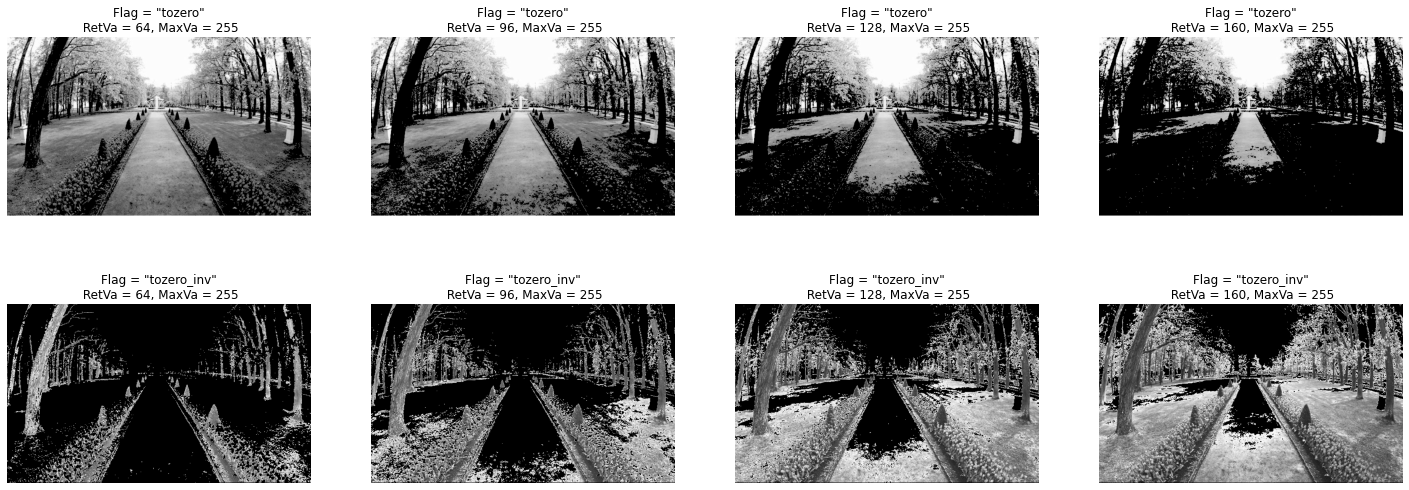

In [10]:
RetVas = [64, 96, 128, 160]
flags = [cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
flag_names = ['tozero', 'tozero_inv']
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 9))
ax = ax.ravel()
for r in range(2):
    for c in range(4):
        RetVa, Ret_Im = cv2.threshold(img_gray, RetVas[c], 255, flags[r])    
        ax[4*r + c].imshow(Ret_Im, cmap = 'gray')
        ax[4*r + c].set_title('Flag = "%s"\n RetVa = %s, MaxVa = %s'%(flag_names[r], RetVas[c], 255))
        ax[4*r + c].set_axis_off()

### 1.3. Truncated_thresholding
Khác hẳn với 2 phần trước đó, từ `truncated` trong `truncated_thresholding` muốn tạo ra một `output image` bị `chặt (truncated)` tại điểm `ngưỡng, RetVa` của giá trị pixel, những điểm chưa đạt ngưỡng này thì vẫn sẽ cố định giá trị của nó. Vì vậy, ta có

$$ f_{\text{trunc}} (x) = \text{RetVa} * 1_{\lbrace x \geq \text{RetVa} \rbrace} + x * 1_{\lbrace x < \text{RetVa} \rbrace} $$

Như vậy, trong trường hợp này thì `output` image cũng không phụ thuộc vào `MaxVa`

In [15]:
print('Given pixel = \n %s'%pixel)
RetVas = [100, 200]
for k in range(2):
    for MaxVa in MaxVas:
        ret_vl, ret_pix = cv2.threshold(pixel, RetVas[k], MaxVa, cv2.THRESH_TRUNC)
        print('For RetVa = %s, MaxVa = %s, flag = "%s", then \n ret_pix = \n %s'%(ret_vl, MaxVa, 'trunc', ret_pix))

Given pixel = 
 [[255 210 230 144 244]
 [121 140 174 121 121]]
For RetVa = 100.0, MaxVa = 220, flag = "trunc", then 
 ret_pix = 
 [[100 100 100 100 100]
 [100 100 100 100 100]]
For RetVa = 100.0, MaxVa = 240, flag = "trunc", then 
 ret_pix = 
 [[100 100 100 100 100]
 [100 100 100 100 100]]
For RetVa = 100.0, MaxVa = 255, flag = "trunc", then 
 ret_pix = 
 [[100 100 100 100 100]
 [100 100 100 100 100]]
For RetVa = 200.0, MaxVa = 220, flag = "trunc", then 
 ret_pix = 
 [[200 200 200 144 200]
 [121 140 174 121 121]]
For RetVa = 200.0, MaxVa = 240, flag = "trunc", then 
 ret_pix = 
 [[200 200 200 144 200]
 [121 140 174 121 121]]
For RetVa = 200.0, MaxVa = 255, flag = "trunc", then 
 ret_pix = 
 [[200 200 200 144 200]
 [121 140 174 121 121]]


**Minh họa**

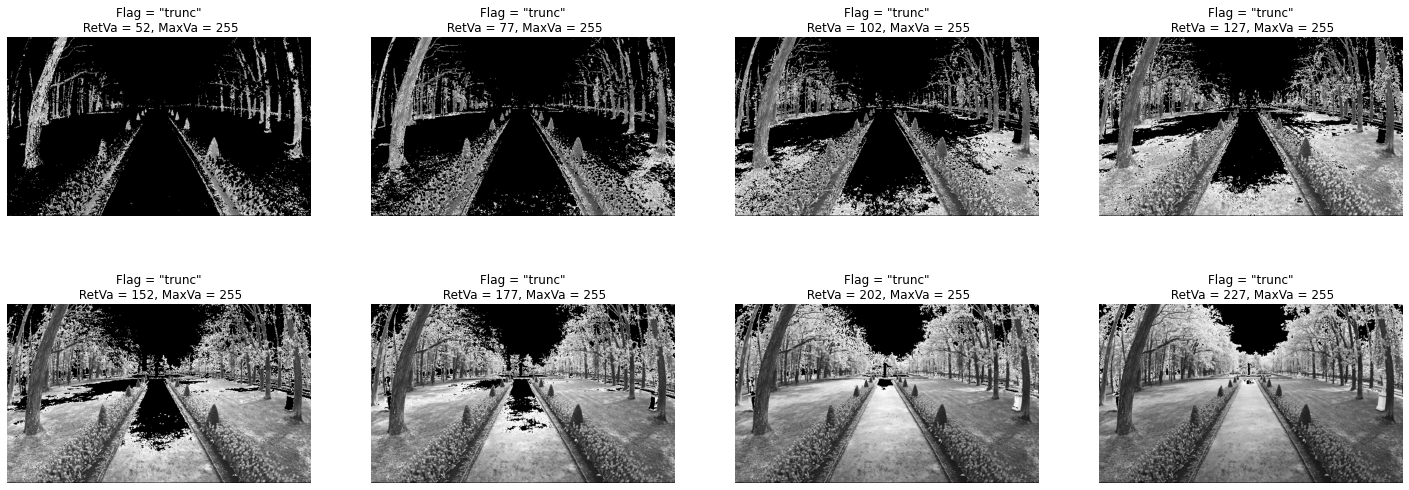

In [22]:
RetVas = list(range(52, 250, 25))
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 9))
ax = ax.ravel()
for c in range(8):
    RetVa, Ret_Im = cv2.threshold(img_gray, RetVas[c], 255, flags[r])    
    ax[c].imshow(Ret_Im, cmap = 'gray')
    ax[c].set_title('Flag = "trunc"\n RetVa = %s, MaxVa = %s'%(RetVas[c], 255))
    ax[c].set_axis_off()

## 2. Exercise-application.
Trong phần BT này, ta sẽ xét ứng dụng của `threshold` khi áp dụng nó làm `mask` cho các hàm `bitwise` trong `object extraction`